### 도서 추천
- 도서 요약 --> Feature 변환 --> 코사인 유사도

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

##### 1. 데이터 탐색

In [2]:
df = pd.read_csv('data/books.csv')
df.head(3)

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...


In [3]:
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
df.head(3)

,Desc,author,genre,image_link,rating,title
0,We know that power is shifting: From West to E...,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,Following the success of The Accidental Billio...,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,How to tap the power of social software and ne...,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...


In [4]:
df.shape

(2382, 6)

In [5]:
df.Desc[0]

"We know that power is shifting: From West to East and North to South, from presidential palaces to public squares, from once formidable corporate behemoths to nimble startups and, slowly but surely, from men to women. But power is not merely shifting and dispersing. It is also decaying. Those in power today are more constrained in what they can do with it and more at risk of losing it than ever before. In The End of Power, award-winning columnist and former Foreign Policy editor Moisés Naím illuminates the struggle between once-dominant megaplayers and the new micropowers challenging them in every field of human endeavor. Drawing on provocative, original research, Naím shows how the antiestablishment drive of micropowers can topple tyrants, dislodge monopolies, and open remarkable new opportunities, but it can also lead to chaos and paralysis. Naím deftly covers the seismic changes underway in business, religion, education, within families, and in all matters of war and peace. Example

##### 2. 데이터 전처리

In [6]:
# 결측치 확인
df.isna().sum().sum()

0

In [7]:
# 중복 데이터 확인
df.shape[0], df.title.nunique(), df.Desc.nunique()

(2382, 2378, 2361)

In [8]:
# 중복 데이터 제거
df.drop_duplicates(subset=['Desc'], inplace=True)
df.drop_duplicates(subset=['title'], inplace=True)
df.shape

(2360, 6)

In [9]:
# 인덱스 정리
df.set_index('title', inplace=True)
df.reset_index(inplace=True)
df.tail(3)

,title,Desc,author,genre,image_link,rating
2357,The Day of the Triffids,In 1951 John Wyndham published his novel The D...,John Wyndham,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.02
2358,A Good Man is Hard to Find and Other Stories,This now classic book revealed Flannery O'Conn...,Flannery O'Connor,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.22
2359,Angela's Ashes,Imbued on every page with Frank McCourt's asto...,Frank McCourt,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.11


##### 3. Feature 변환

In [10]:
# 저자와 장르 필드의 공백 제거
df.author = df.author.str.replace(' ', '')
df.genre = df.genre.str.replace(' ', '')

In [11]:
# 저자와 장르 필드는 강조
df['total'] = df.Desc + (' ' + df.author) * 3 + (' ' + df.genre) * 2

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
cvect = CountVectorizer(stop_words='english')
total_cv = cvect.fit_transform(df.total)
total_cv.shape

(2360, 29149)

In [13]:
# 검색을 쉽게 하기 위해서 책 타이틀과 인덱스를 가진 테이블
indices = pd.Series(df.index, index=df.title)

##### 4. 코사인 유사도

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(total_cv)

In [15]:
def get_recommendation(title, cos_sim):
    index = indices[title]
    sim_scores = pd.Series(cos_sim[index])
    book_indices = sim_scores.sort_values(ascending=False).head(11).tail(10).index
    return df.title.iloc[book_indices]

In [16]:
get_recommendation('The Day of the Triffids', cosine_sim)

1490              A Separate Peace
1312                     The Stand
1329                    Neverwhere
1844                   Post Office
2327           The Lathe of Heaven
2107                   Left Behind
2208               The Time Keeper
1792                 The Overstory
1465    The Man in the High Castle
1199               Brave New World
Name: title, dtype: object

##### 5. 추천도서 이미지 출력

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

In [19]:
results = get_recommendation('The Da Vinci Code', cosine_sim)
results

1277                 The Lost Symbol
1568                          Origin
1207                 Angels & Demons
1332                         Inferno
1376                Digital Fortress
2107                     Left Behind
2014    The Invention of Hugo Cabret
1377          Breakfast of Champions
2042               Second Foundation
1384                 Deception Point
Name: title, dtype: object

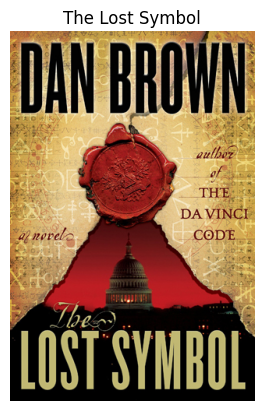

In [22]:
index = 1277
response = requests.get(df.image_link[index])
img = Image.open(BytesIO(response.content))
plt.imshow(img), plt.axis('off')
plt.title(df.title[index]);

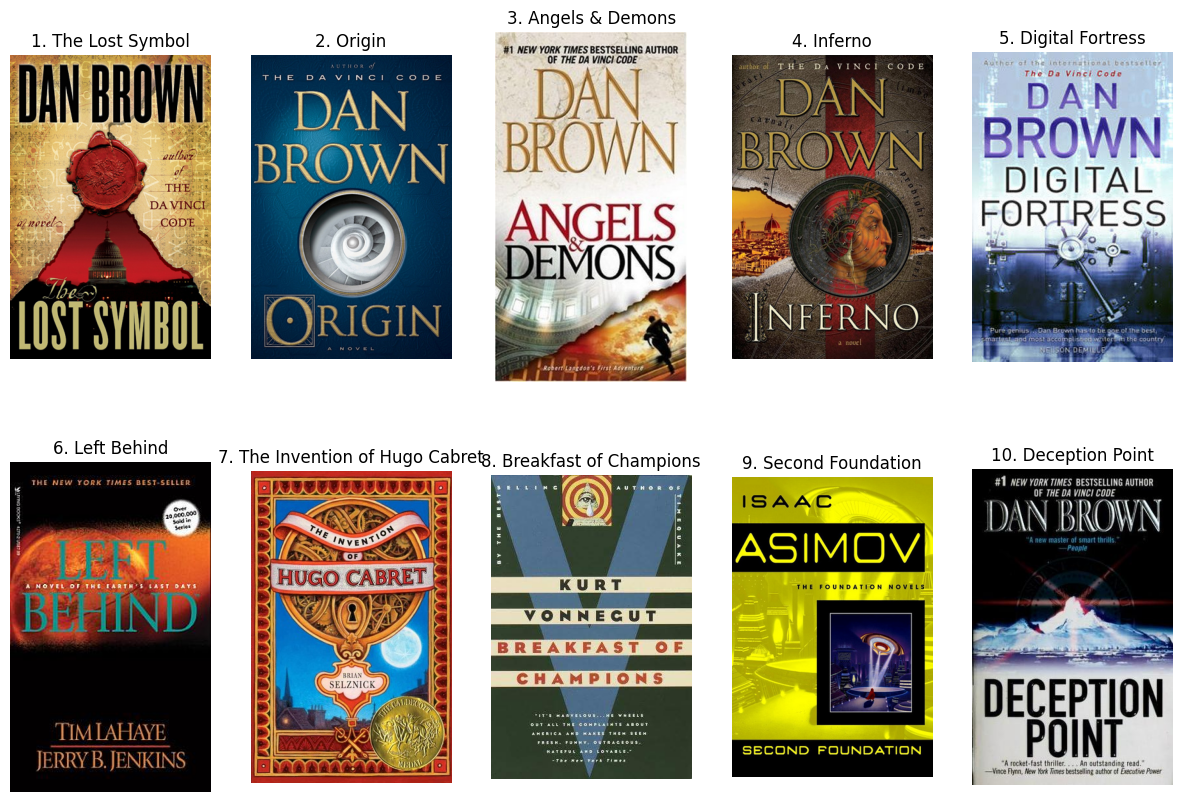

In [24]:
plt.figure(figsize=(15, 10))
for i, index in enumerate(results.index):
    response = requests.get(df.image_link[index])
    img = Image.open(BytesIO(response.content))
    plt.subplot(2, 5, i+1)
    plt.imshow(img), plt.axis('off')
    plt.title(f'{i+1}. ' + df.title[index])
plt.show()